In [ ]:
!hostname

n120.clstr


In [121]:
import xarray as xr
import os
import glob
import geopandas as gpd
import matplotlib.colors as mcolors
import pandas as pd
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import regionmask
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

In [3]:
shapefile_path = "/center1/DYNDOWN/phutton5/ROS/boundaries/Alaska_Borough_and_Census_Area_Boundaries.shp"
borough_boundaries = gpd.read_file(shapefile_path)
borough_boundaries = borough_boundaries.set_crs(epsg=3338)
borough_boundaries = borough_boundaries.to_crs(epsg=4326)
FNSB_boundary = borough_boundaries[borough_boundaries['CommunityN'] == 'Fairbanks North Star Borough']
FNSB_geom = FNSB_boundary.geometry.iloc[0] 
FNSB_coords = []
FNSB_coords.extend(list(FNSB_geom.exterior.coords))
FNSB_coords = np.array(FNSB_coords)  
FNSB_coords = pd.DataFrame({
    "lon": FNSB_coords[:, 0],
    "lat": FNSB_coords[:, 1]
})

Fairbanks_lat=(64.84)
Fairbanks_lon=(-147.72)

Mun_of_Anc_boundary = borough_boundaries[borough_boundaries['CommunityN'] == 'Municipality of Anchorage']
Bethel_boundary = borough_boundaries[borough_boundaries['CommunityN'] == 'Bethel Census Area']
Mat_Su_boundary=borough_boundaries[borough_boundaries['CommunityN'] == 'Matanuska-Susitna Borough']
Denali_boundary=borough_boundaries[borough_boundaries['CommunityN'] == 'Denali Borough']

In [4]:
path='/center1/DYNDOWN/phutton5/ROS/All_of_AK/All_of_AK_netcdf_files/'
compare=f'ROS_Monthly_*.nc'
file_list = sorted(glob.glob(os.path.join(path, compare)))
combined_ds=xr.open_mfdataset(file_list, combine='by_coords',engine='netcdf4')

os.chdir("/import/beegfs/CMIP6/wrf_era5")
geo_em_path = "geo_em.d02.nc"
geo = xr.open_dataset(geo_em_path)
oceanmask=geo['LU_INDEX']
oceanmask=oceanmask.squeeze(dim='Time')
#oceanmask_expanded = oceanmask.expand_dims(Time=data.Time)

combined_ds = combined_ds.where(oceanmask != 17)
era5_4km=combined_ds

era54kmlat = combined_ds['XLAT'].values
era54kmlon = combined_ds['XLONG'].values

ROS_Tally_era5_4km=np.sum(era5_4km['ros_tally'],axis=1)
ROS_Tally_seasonal_era5_4km=np.mean(ROS_Tally_era5_4km,axis=0)

ROS_Rain_sum_era5_4km=np.sum(era5_4km['rain_ros_sum'],axis=1)
ROS_Rain_seasonal_sum_era5_4km=np.mean(ROS_Rain_sum_era5_4km,axis=0)

lat = combined_ds['XLAT'].values
lon = combined_ds['XLONG'].values

In [5]:
ERA5_31km_REGRIDDED_ERA5_4km=xr.open_dataset('/center1/DYNDOWN/phutton5/ROS/All_of_AK/All_of_AK_netcdf_files/ERA5_31kmto4km_nearest_regridded.nc', engine='netcdf4')
ERA5_31km_REGRIDDED_ERA5_4km.transpose("south_north", "west_east",...)
ERA5_31km_REGRIDDED_ERA5_4km = ERA5_31km_REGRIDDED_ERA5_4km.where(oceanmask != 17)

ROS_Tally_nearest_regridded_ERA5_31km=np.sum(ERA5_31km_REGRIDDED_ERA5_4km['ros_tally'],axis=(1))
ROS_Tally_seasonal_nearest_regridded_ERA5_31km=np.mean(ROS_Tally_nearest_regridded_ERA5_31km,axis=(0))
ROS_Tally_seasonal_nearest_regridded_ERA5_31km=ROS_Tally_seasonal_nearest_regridded_ERA5_31km.fillna(0)

ROS_RAIN_SUM_nearest_regridded_ERA5_31km=np.sum(ERA5_31km_REGRIDDED_ERA5_4km['rain_ros_sum'],axis=(1))
ROS_RAIN_SUM_nearest_regridded_ERA5_31km=np.mean(ROS_RAIN_SUM_nearest_regridded_ERA5_31km,axis=(0))
ROS_RAIN_SUM_nearest_regridded_ERA5_31km=ROS_RAIN_SUM_nearest_regridded_ERA5_31km.fillna(0)


In [6]:
Difference_ROS_seasonal=ROS_Tally_seasonal_era5_4km-ROS_Tally_seasonal_nearest_regridded_ERA5_31km

In [180]:
#ros_colorbar = LinearSegmentedColormap.from_list('ros', ["saddlebrown", 'white', "darkblue"])
ros_colorbar = LinearSegmentedColormap.from_list('ros', ['darkred', 'orange', 'white', 'deepskyblue', 'midnightblue'])
#ros_colorbar = LinearSegmentedColormap.from_list('ros', ['#B86B4B', '#F1E5C0', '#5C6F8E'])
#ros_colorbar = LinearSegmentedColormap.from_list('ros', ['#B86B4B', 'white', '#5C6F8E'])

#ros_colorbar = LinearSegmentedColormap.from_list('ros', ['#B86B4B', 'white', '#4682B4'])
#ros_colorbar = LinearSegmentedColormap.from_list('ros', ['#B86B4B', '#D47F4D', 'white', '#6C8DA5', '#4682B4'])
#ros_colorbar = LinearSegmentedColormap.from_list('ros', ['#B86B4B', '#D47F4D', 'white', '#F0A500', '#1D4E89'])
ros_colorbar = LinearSegmentedColormap.from_list('ros', [
    '#4B2D1A',  
    '#6B3F1E',  
    '#A0522D',  
    '#D2B48C',  
    'white',     
    '#A1C6E8',  
    '#4682B4',  
    '#1E3A5F',  
    '#0A1F38'   
])




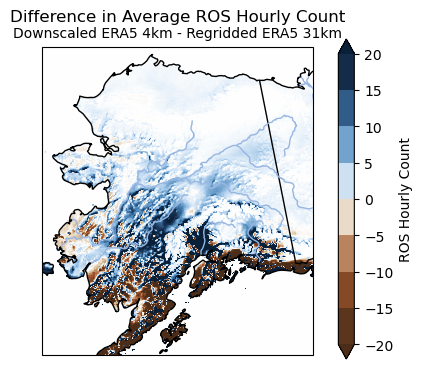

In [179]:
AK_ALBERS_SUBPLOT_KW = {'projection': ccrs.AlbersEqualArea(central_longitude=-154, central_latitude=50,standard_parallels=(55, 65))}
fig, ax = plt.subplots(subplot_kw=AK_ALBERS_SUBPLOT_KW, figsize=(10, 4))
fig.patch.set_alpha(0)
ax.set_facecolor('none')
levels=np.arange(-20,25,5)
cf = ax.pcolormesh(era54kmlon, era54kmlat, Difference_ROS_seasonal,vmin=-20, vmax=20,cmap=ros_colorbar,shading='auto',transform=ccrs.PlateCarree())

cbar = fig.colorbar(cf, ax=ax, boundaries=levels,label='ROS Hourly Count',extend='both',ticks=levels)
cbar.ax.set_position([0.77, 0.1, 0.02, 0.8])
ax.add_feature(cfeature.BORDERS, zorder=9)
ax.add_feature(cfeature.COASTLINE, zorder=9)
ax.add_feature(cfeature.RIVERS, zorder=9)
#ax.text(Fairbanks_lon, Fairbanks_lat + 0.05, 'Fairbanks', transform=ccrs.PlateCarree(),
#        ha='center', va='bottom', fontsize=8, zorder=6, fontweight='bold', color='black')

ax.set_title("Difference in Average ROS Hourly Count\n",fontsize=12)
ax.text(0.5, 1.03, "Downscaled ERA5 4km - Regridded ERA5 31km", transform=ax.transAxes, fontsize=10, ha='center')
ax.set_extent([-165.3, -141, 55.8, 71.38], crs=ccrs.PlateCarree())
ax.set_aspect('equal') 
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.show()

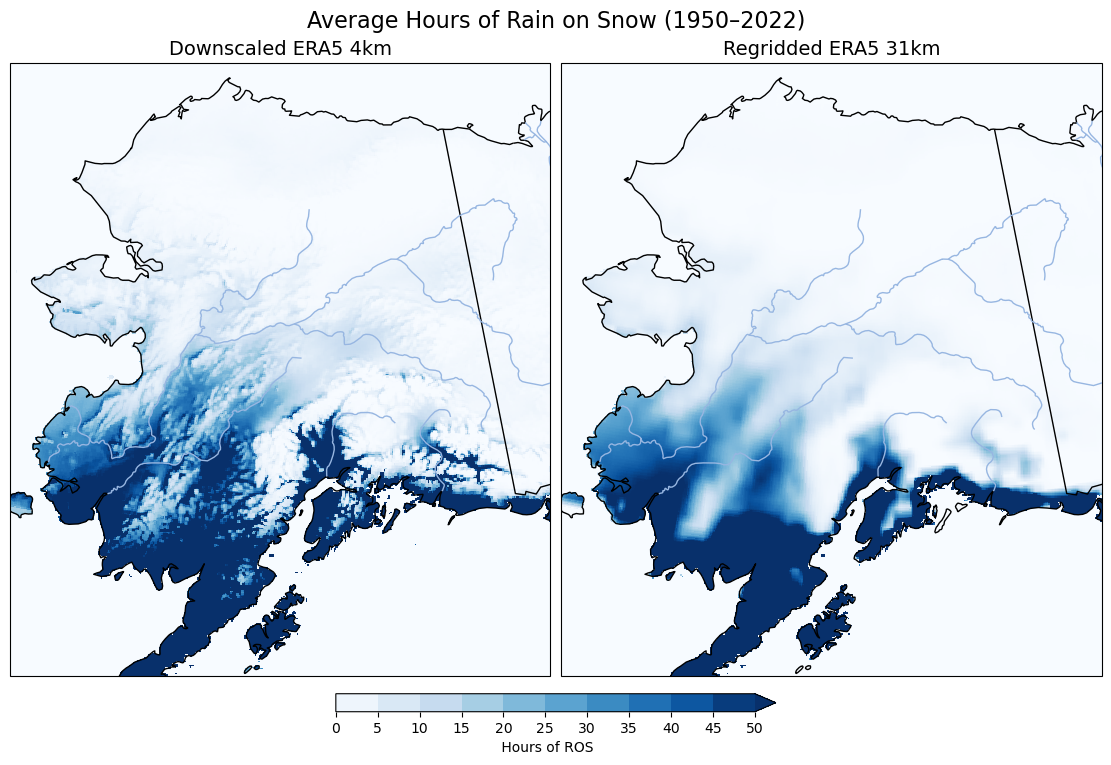

In [ ]:

AK_ALBERS_SUBPLOT_KW = {
    'projection': ccrs.AlbersEqualArea(
        central_longitude=-154, central_latitude=50,
        standard_parallels=(55, 65))}

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(11,9), subplot_kw=AK_ALBERS_SUBPLOT_KW, constrained_layout=True)

cmap = 'Blues'
levels=np.arange(0, 55, 5)

# Use pcolormesh instead of contourf
pc1 = axs[0].pcolormesh(ROS_Tally_seasonal_era5_4km['XLONG'], ROS_Tally_seasonal_era5_4km['XLAT'], 
                        ROS_Tally_seasonal_era5_4km, 
                        cmap=cmap, 
                        vmin=levels[0], vmax=levels[-1], 
                        shading='auto', transform=ccrs.PlateCarree())

axs[0].set_title("Downscaled ERA5 4km", fontsize=14)

# Use pcolormesh for ERA5 31km data
pc2 = axs[1].pcolormesh(ROS_Tally_seasonal_nearest_regridded_ERA5_31km['XLONG'], ROS_Tally_seasonal_nearest_regridded_ERA5_31km['XLAT'], 
                        ROS_Tally_seasonal_nearest_regridded_ERA5_31km, 
                        cmap=cmap, 
                        vmin=levels[0], vmax=levels[-1], 
                        shading='auto', transform=ccrs.PlateCarree())

axs[1].set_title("Regridded ERA5 31km", fontsize=14)

for ax in axs:
    #FNSB_boundary.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=1, zorder=2, transform=ccrs.PlateCarree())
    #ax.scatter(Fairbanks_lon, Fairbanks_lat, marker='*', color='k', s=75, zorder=9, transform=ccrs.PlateCarree())
    #ax.text(Fairbanks_lon, Fairbanks_lat + 0.2, 'Fairbanks', ha='center', va='bottom', fontsize=8,
    #        fontweight='bold', color='black', zorder=6, transform=ccrs.PlateCarree())
    ax.add_feature(cfeature.BORDERS, zorder=8)
    ax.add_feature(cfeature.COASTLINE, zorder=8)
    ax.add_feature(cfeature.RIVERS, zorder=8)
    ax.set_extent([-165.3, -141, 55.8, 71.38], crs=ccrs.PlateCarree())
    ax.set_aspect('equal')
fig.suptitle("Average Hours of Rain on Snow (1950–2022)",fontsize=16, y=0.90)

cbar_ax = fig.add_axes([0.3, 0.12, 0.4, 0.02])
fig.colorbar(pc1, cax=cbar_ax, boundaries=levels,extend='max',orientation='horizontal', label=' Hours of ROS', ticks=levels)

fig.patch.set_alpha(0.0)
plt.show()

In [11]:
#Rain ros sum 
#ROS_RAIN_SUM_nearest_regridded_ERA5_4km
#ROS_RAIN_SUM_Bilinear_regridded_ERA5_4km

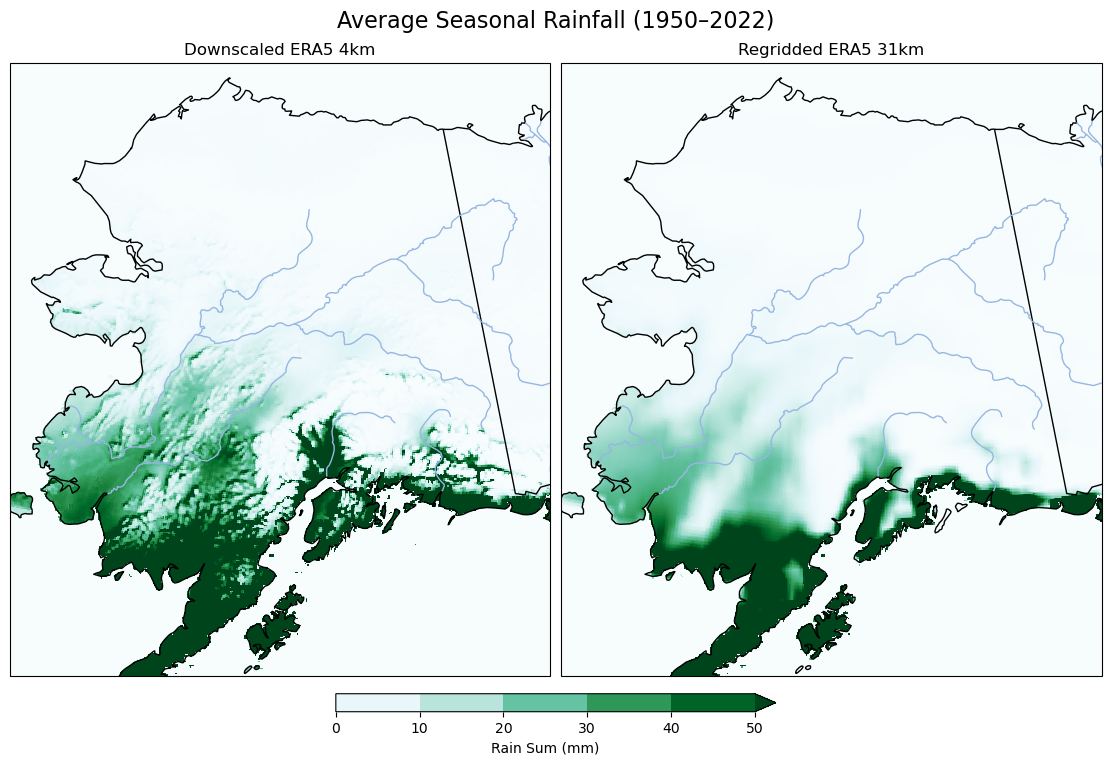

In [16]:
AK_ALBERS_SUBPLOT_KW = {
    'projection': ccrs.AlbersEqualArea(
        central_longitude=-154, central_latitude=50,
        standard_parallels=(55, 65))}

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(11,9), subplot_kw=AK_ALBERS_SUBPLOT_KW, constrained_layout=True)

# Create color map and levels
cmap = 'BuGn'
levels=np.arange(0, 60, 10)

# Use pcolormesh instead of contourf
pc1 = axs[0].pcolormesh(ROS_Rain_seasonal_sum_era5_4km['XLONG'], ROS_Rain_seasonal_sum_era5_4km['XLAT'], 
                        ROS_Rain_seasonal_sum_era5_4km, 
                        cmap=cmap, 
                        vmin=levels[0], vmax=levels[-1], 
                        shading='auto', transform=ccrs.PlateCarree())

axs[0].set_title("Downscaled ERA5 4km", fontsize=12)

# Use pcolormesh for ERA5 31km data
pc2 = axs[1].pcolormesh(ROS_RAIN_SUM_nearest_regridded_ERA5_31km['XLONG'], ROS_RAIN_SUM_nearest_regridded_ERA5_31km['XLAT'], 
                        ROS_RAIN_SUM_nearest_regridded_ERA5_31km, 
                        cmap=cmap, 
                        vmin=levels[0], vmax=levels[-1], 
                        shading='auto', transform=ccrs.PlateCarree())
axs[1].set_title("Regridded ERA5 31km", fontsize=12)

for ax in axs:
    ax.add_feature(cfeature.BORDERS, zorder=8)
    ax.add_feature(cfeature.COASTLINE, zorder=8)
    ax.add_feature(cfeature.RIVERS, zorder=8)
    ax.set_extent([-165.3, -141, 55.8, 71.38], crs=ccrs.PlateCarree())
    ax.set_aspect('equal')

cbar_ax = fig.add_axes([0.3, 0.12, 0.4, 0.02])
fig.colorbar(pc1,extend='max', cax=cbar_ax,boundaries=levels,orientation='horizontal', label='Rain Sum (mm)', ticks=levels)
fig.suptitle("Average Seasonal Rainfall (1950–2022)",fontsize=16, y=0.90)
fig.patch.set_alpha(0.0)
plt.show()

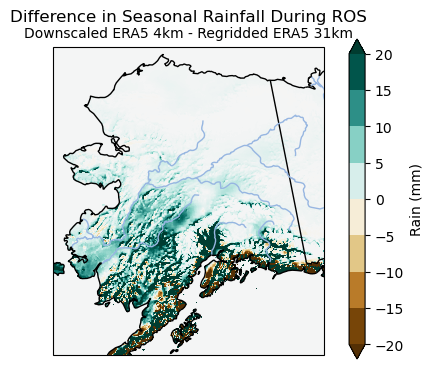

In [193]:
Rain_difference=(ROS_Rain_seasonal_sum_era5_4km-ROS_RAIN_SUM_nearest_regridded_ERA5_31km)

AK_ALBERS_SUBPLOT_KW = {
    'projection': ccrs.AlbersEqualArea(
        central_longitude=-154,
        central_latitude=50,
        standard_parallels=(55, 65))}

fig, ax = plt.subplots(subplot_kw=AK_ALBERS_SUBPLOT_KW, figsize=(10, 4))

levels=np.arange(-20, 25, 5)
# Make background transparent
fig.patch.set_alpha(0)
ax.set_facecolor('none')

pcm = ax.pcolormesh(
    lon, lat, Rain_difference,
    cmap='BrBG',
    vmin=-20, vmax=20,
    shading='auto',
    transform=ccrs.PlateCarree()
)

cbar = fig.colorbar(pcm, ax=ax,boundaries=levels, label='Rain (mm)',extend='both')
cbar.set_ticks(levels)
cbar.ax.set_position([0.77, 0.1, 0.02, 0.8])

# Map features
ax.add_feature(cfeature.BORDERS, zorder=9)
ax.add_feature(cfeature.COASTLINE, zorder=9)
ax.add_feature(cfeature.RIVERS, zorder=9)

ax.set_title("Difference in Seasonal Rainfall During ROS\n",fontsize=12)
ax.text(0.5, 1.03, "Downscaled ERA5 4km - Regridded ERA5 31km", transform=ax.transAxes, fontsize=10, ha='center')

ax.set_extent([-165.3, -141, 55.8, 71.38], crs=ccrs.PlateCarree())
ax.set_aspect('equal')
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

plt.show()


In [184]:
Rain_difference=(ROS_RAIN_SUM_nearest_regridded_ERA5_4km-ROS_rain_sum_era5_31km)

AK_ALBERS_SUBPLOT_KW = {
    'projection': ccrs.AlbersEqualArea(
        central_longitude=-154,
        central_latitude=50,
        standard_parallels=(55, 65))}

fig, ax = plt.subplots(subplot_kw=AK_ALBERS_SUBPLOT_KW, figsize=(10, 4))

# Make background transparent
fig.patch.set_alpha(0)
ax.set_facecolor('none')

pcm = ax.pcolormesh(
    lon, lat, Rain_difference,
    cmap='coolwarm',
    vmin=-10, vmax=10,
    shading='auto',
    transform=ccrs.PlateCarree()
)

cbar = fig.colorbar(pcm, ax=ax, label='Rain (mm)')
cbar.set_ticks(np.arange(-10, 11, 1))
cbar.ax.set_position([0.77, 0.1, 0.02, 0.8])

# Map features
ax.add_feature(cfeature.BORDERS, zorder=9)
ax.add_feature(cfeature.COASTLINE, zorder=9)
ax.add_feature(cfeature.RIVERS, zorder=9)

ax.set_title(
    "Difference in Seasonal Rainfall During ROS\n"
    "Regridded ERA5 4km - ERA5 31km \n"
    "for Winter 1950–2022"
)

ax.set_extent([-165.3, -141, 55.8, 71.38], crs=ccrs.PlateCarree())
ax.set_aspect('equal')
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

plt.show()

NameError: name 'ROS_RAIN_SUM_nearest_regridded_ERA5_4km' is not defined

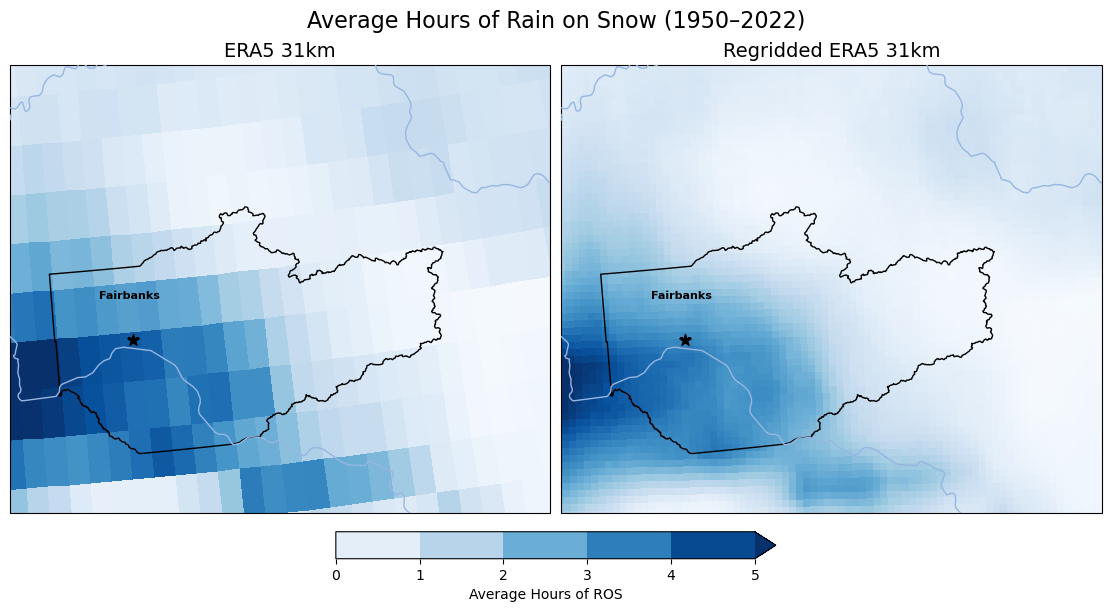

In [28]:
path='/center1/DYNDOWN/phutton5/ROS/Raw_ERA5/Raw_ERA5_netcdf'
pattern=f'Raw_ERA5_ROS_Monthly*.nc'
file_list = sorted(glob.glob(os.path.join(path, pattern)))
ERA5_raw = xr.open_mfdataset(file_list, combine='by_coords',engine='netcdf4')
#data = data.fillna(0)


AK_ALBERS_SUBPLOT_KW = {
    'projection': ccrs.AlbersEqualArea(
        central_longitude=-154, central_latitude=50,
        standard_parallels=(55, 65))}

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(11,9), subplot_kw=AK_ALBERS_SUBPLOT_KW, constrained_layout=True)

# Create color map and levels
cmap = 'Blues'
levels=np.arange(0,6,1)

# Use pcolormesh instead of contourf
pc1 = axs[0].pcolormesh(ERA5_raw['longitude'], ERA5_raw['latitude'], 
                        np.mean(ERA5_raw['ros_tally'].sum(dim='month'),axis=0), 
                        cmap=cmap, 
                        vmin=levels[0], vmax=levels[-1], 
                        shading='auto', transform=ccrs.PlateCarree())

axs[0].set_title("ERA5 31km", fontsize=14)

# Use pcolormesh for ERA5 31km data
pc2 = axs[1].pcolormesh(ROS_Tally_seasonal_nearest_regridded_ERA5_31km['XLONG'], ROS_Tally_seasonal_nearest_regridded_ERA5_31km['XLAT'], 
                        ROS_Tally_seasonal_nearest_regridded_ERA5_31km, 
                        cmap=cmap, 
                        vmin=levels[0], vmax=levels[-1], 
                        shading='auto', transform=ccrs.PlateCarree())

axs[1].set_title("Regridded ERA5 31km", fontsize=14)

for ax in axs:
    FNSB_boundary.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=1, zorder=2, transform=ccrs.PlateCarree())
    ax.scatter(Fairbanks_lon, Fairbanks_lat, marker='*', color='k', s=75, zorder=9, transform=ccrs.PlateCarree())
    ax.text(Fairbanks_lon, Fairbanks_lat + 0.2, 'Fairbanks', ha='center', va='bottom', fontsize=8,
            fontweight='bold', color='black', zorder=6, transform=ccrs.PlateCarree())
    ax.add_feature(cfeature.BORDERS, zorder=8)
    ax.add_feature(cfeature.COASTLINE, zorder=8)
    ax.add_feature(cfeature.RIVERS, zorder=8)
    ax.set_extent([-149, -143, 64, 66], crs=ccrs.PlateCarree())
    ax.set_aspect('equal')
fig.suptitle("Average Hours of Rain on Snow (1950–2022)",fontsize=16, y=0.81)
cbar_ax = fig.add_axes([0.3, 0.20, 0.4, 0.03])
fig.colorbar(pc1, cax=cbar_ax,boundaries=levels, orientation='horizontal', label='Average Hours of ROS', ticks=levels,extend='max')

fig.patch.set_alpha(0.0)
plt.show()

FAIRBANKS
-

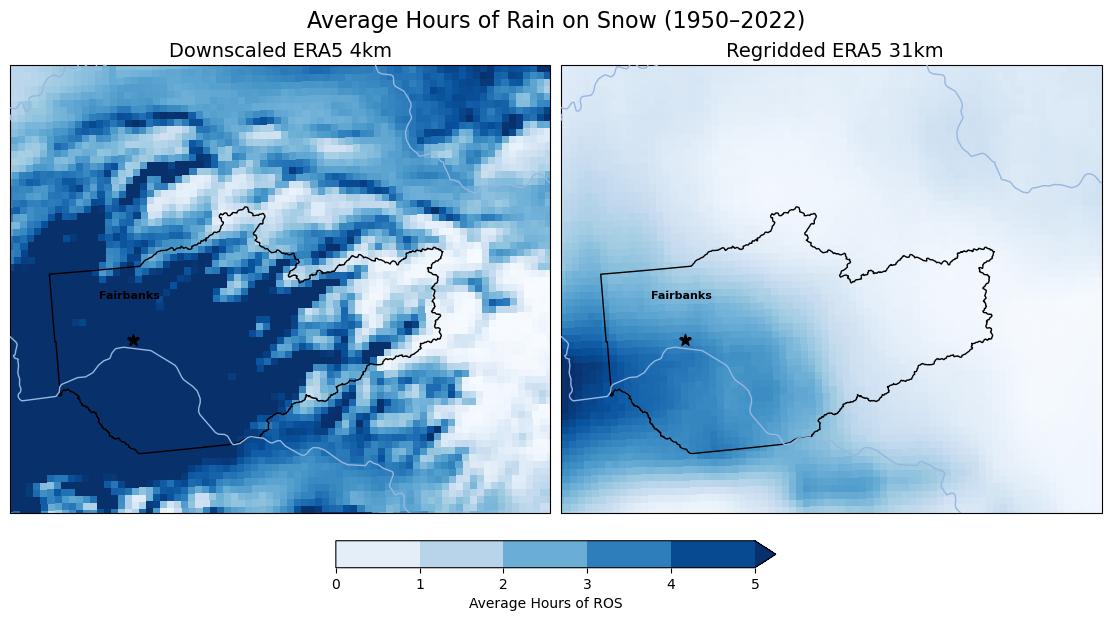

In [29]:
AK_ALBERS_SUBPLOT_KW = {
    'projection': ccrs.AlbersEqualArea(
        central_longitude=-154, central_latitude=50,
        standard_parallels=(55, 65))}

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(11,9), subplot_kw=AK_ALBERS_SUBPLOT_KW, constrained_layout=True)

# Create color map and levels
cmap = 'Blues'
levels=np.arange(0,6,1)

# Use pcolormesh instead of contourf
pc1 = axs[0].pcolormesh(ROS_Tally_era5_4km['XLONG'], ROS_Tally_era5_4km['XLAT'], 
                        ROS_Tally_seasonal_era5_4km, 
                        cmap=cmap, 
                        vmin=levels[0], vmax=levels[-1], 
                        shading='auto', transform=ccrs.PlateCarree())

axs[0].set_title("Downscaled ERA5 4km", fontsize=14)

# Use pcolormesh for ERA5 31km data
pc2 = axs[1].pcolormesh(ROS_Tally_seasonal_nearest_regridded_ERA5_31km['XLONG'], ROS_Tally_seasonal_nearest_regridded_ERA5_31km['XLAT'], 
                        ROS_Tally_seasonal_nearest_regridded_ERA5_31km, 
                        cmap=cmap, 
                        vmin=levels[0], vmax=levels[-1], 
                        shading='auto', transform=ccrs.PlateCarree())

axs[1].set_title(" Regridded ERA5 31km", fontsize=14)

for ax in axs:
    FNSB_boundary.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=1, zorder=2, transform=ccrs.PlateCarree())
    ax.scatter(Fairbanks_lon, Fairbanks_lat, marker='*', color='k', s=75, zorder=9, transform=ccrs.PlateCarree())
    ax.text(Fairbanks_lon, Fairbanks_lat + 0.2, 'Fairbanks', ha='center', va='bottom', fontsize=8,
            fontweight='bold', color='black', zorder=6, transform=ccrs.PlateCarree())
    ax.add_feature(cfeature.BORDERS, zorder=8)
    ax.add_feature(cfeature.COASTLINE, zorder=8)
    ax.add_feature(cfeature.RIVERS, zorder=8)
    ax.set_extent([-149, -143, 64, 66], crs=ccrs.PlateCarree())
    ax.set_aspect('equal')
fig.suptitle("Average Hours of Rain on Snow (1950–2022)",fontsize=16, y=0.81)
cbar_ax = fig.add_axes([0.3, 0.19, 0.4, 0.03])
fig.colorbar(pc1, cax=cbar_ax, orientation='horizontal',boundaries=levels, label='Average Hours of ROS', ticks=levels,extend='max')

fig.patch.set_alpha(0.0)
plt.show()

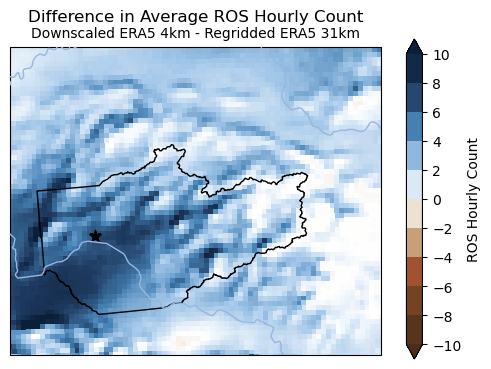

In [185]:
AK_ALBERS_SUBPLOT_KW = {
    'projection': ccrs.AlbersEqualArea(
        central_longitude=-154,
        central_latitude=50,
        standard_parallels=(55, 65))}

fig, ax = plt.subplots(subplot_kw=AK_ALBERS_SUBPLOT_KW, figsize=(10, 4))

fig.patch.set_alpha(0)
ax.set_facecolor('none')

levels=np.arange(-10, 12, 2)

pcm = ax.pcolormesh(
    lon, lat, Difference_ROS_seasonal,
    cmap=ros_colorbar,
    vmin=-10, vmax=10,
    shading='auto',
    transform=ccrs.PlateCarree()
)

cbar = fig.colorbar(pcm, ax=ax, boundaries=levels, label='ROS Hourly Count',extend='both')
cbar.set_ticks(levels)
cbar.ax.set_position([0.77, 0.1, 0.02, 0.8])

FNSB_boundary.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=1, zorder=2, transform=ccrs.PlateCarree())
ax.scatter(
    Fairbanks_lon, Fairbanks_lat,
    marker='*', color='k',
    zorder=5, s=75,
    label='Fairbanks',
    transform=ccrs.PlateCarree())

# Map features
ax.add_feature(cfeature.BORDERS, zorder=9)
ax.add_feature(cfeature.COASTLINE, zorder=9)
ax.add_feature(cfeature.RIVERS, zorder=9)
ax.text(0.5, 1.03, "Downscaled ERA5 4km - Regridded ERA5 31km", transform=ax.transAxes, fontsize=10, ha='center')
ax.set_title("Difference in Average ROS Hourly Count\n")

ax.set_extent([-149, -143, 64, 66], crs=ccrs.PlateCarree())
ax.set_aspect('equal')
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

plt.show()

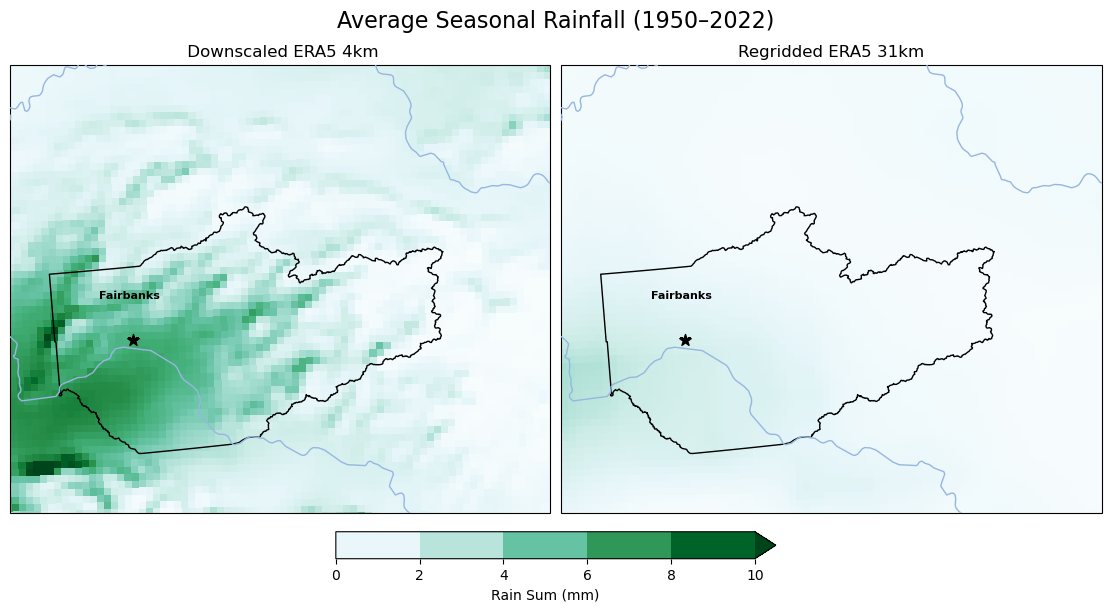

In [49]:
AK_ALBERS_SUBPLOT_KW = {
    'projection': ccrs.AlbersEqualArea(
        central_longitude=-154, central_latitude=50,
        standard_parallels=(55, 65))}

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(11,9), subplot_kw=AK_ALBERS_SUBPLOT_KW, constrained_layout=True)

# Create color map and levels
cmap = 'BuGn'
levels=np.arange(0, 12, 2)
# Use pcolormesh instead of contourf
pc1 = axs[0].pcolormesh(ROS_Rain_seasonal_sum_era5_4km['XLONG'], ROS_Rain_seasonal_sum_era5_4km['XLAT'], 
                        ROS_Rain_seasonal_sum_era5_4km, 
                        cmap=cmap, 
                        vmin=levels[0], vmax=levels[-1], 
                        shading='auto', transform=ccrs.PlateCarree())

axs[0].set_title(" Downscaled ERA5 4km", fontsize=12)

# Use pcolormesh for ERA5 31km data
pc2 = axs[1].pcolormesh(ROS_RAIN_SUM_nearest_regridded_ERA5_31km['XLONG'], ROS_RAIN_SUM_nearest_regridded_ERA5_31km['XLAT'], 
                        ROS_RAIN_SUM_nearest_regridded_ERA5_31km, 
                        cmap=cmap, 
                        vmin=levels[0], vmax=levels[-1], 
                        shading='auto', transform=ccrs.PlateCarree())
#average seasonal sum of rainfall during ROS events 
#Average Seasonal Rainfall from Winter 1950-2022 
axs[1].set_title("Regridded ERA5 31km", fontsize=12)

for ax in axs:
    FNSB_boundary.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=1, zorder=2, transform=ccrs.PlateCarree())
    ax.scatter(Fairbanks_lon, Fairbanks_lat, marker='*', color='k', s=75, zorder=9, transform=ccrs.PlateCarree())
    ax.text(Fairbanks_lon, Fairbanks_lat + 0.2, 'Fairbanks', ha='center', va='bottom', fontsize=8,
            fontweight='bold', color='black', zorder=6, transform=ccrs.PlateCarree())
    ax.add_feature(cfeature.BORDERS, zorder=8)
    ax.add_feature(cfeature.COASTLINE, zorder=8)
    ax.add_feature(cfeature.RIVERS, zorder=8)
    ax.set_extent([-149, -143, 64, 66], crs=ccrs.PlateCarree())
    ax.set_aspect('equal')

#fig.suptitle("Average Hours of Rain on Snow (1950–2022)",fontsize=16, y=0.81)
fig.suptitle("Average Seasonal Rainfall (1950–2022)",fontsize=16, y=0.81)
cbar_ax = fig.add_axes([0.3, 0.20, 0.4, 0.03])
fig.colorbar(pc1,extend='max', cax=cbar_ax,boundaries=levels, orientation='horizontal', label='Rain Sum (mm)', ticks=levels)

fig.patch.set_alpha(0.0)
plt.show()

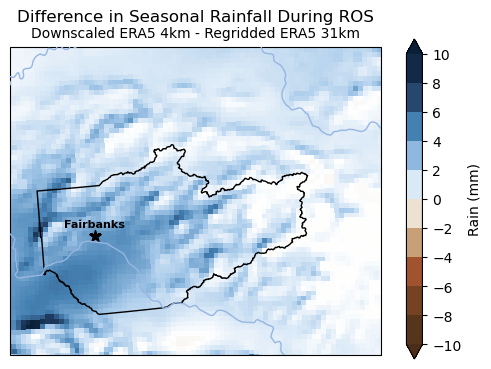

In [187]:
AK_ALBERS_SUBPLOT_KW = {'projection': ccrs.AlbersEqualArea(
        central_longitude=-154,
        central_latitude=50,
        standard_parallels=(55, 65))}

fig, ax = plt.subplots(subplot_kw=AK_ALBERS_SUBPLOT_KW, figsize=(10, 4))
fig.patch.set_alpha(0)
levels=(np.arange(-10, 12, 2))
ax.set_facecolor('none')
pcm = ax.pcolormesh(
    lon, lat, Rain_difference,
    cmap=ros_colorbar,
    vmin=-10, vmax=10,
    shading='auto',
    transform=ccrs.PlateCarree())

cbar = fig.colorbar(pcm, ax=ax,boundaries=levels, label='Rain (mm)',extend='both')
cbar.set_ticks(levels)
cbar.ax.set_position([0.77, 0.1, 0.02, 0.8])

FNSB_boundary.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=1, zorder=2, transform=ccrs.PlateCarree())
ax.scatter(
    Fairbanks_lon, Fairbanks_lat,
    marker='*', color='k',
    zorder=5, s=75,
    label='Fairbanks',
    transform=ccrs.PlateCarree())

ax.add_feature(cfeature.BORDERS, zorder=9)
ax.add_feature(cfeature.COASTLINE, zorder=9)
ax.add_feature(cfeature.RIVERS, zorder=9)

ax.text(
    Fairbanks_lon, Fairbanks_lat + 0.05, 'Fairbanks',
    transform=ccrs.PlateCarree(),
    ha='center', va='bottom',
    fontsize=8, zorder=6,
    fontweight='bold', color='black')

ax.text(0.5, 1.03, "Downscaled ERA5 4km - Regridded ERA5 31km", transform=ax.transAxes, fontsize=10, ha='center')
ax.set_title("Difference in Seasonal Rainfall During ROS\n")
ax.set_extent([-149, -143, 64, 66], crs=ccrs.PlateCarree())
ax.set_aspect('equal')
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.show()

BETHEL
-

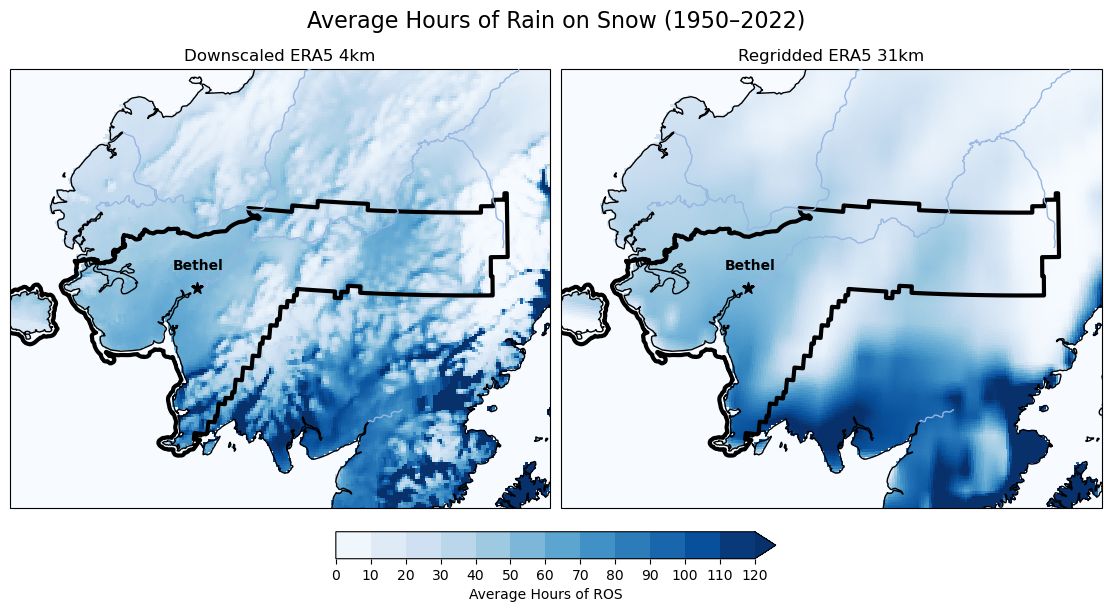

In [53]:
AK_ALBERS_SUBPLOT_KW = {
    'projection': ccrs.AlbersEqualArea(
        central_longitude=-154, central_latitude=50,
        standard_parallels=(55, 65))}

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(11,9), subplot_kw=AK_ALBERS_SUBPLOT_KW, constrained_layout=True)

# Create color map and levels
cmap = 'Blues'

levels=np.arange(0,130,10)

# Use pcolormesh instead of contourf
pc1 = axs[0].pcolormesh(ROS_Tally_era5_4km['XLONG'], ROS_Tally_era5_4km['XLAT'], 
                        ROS_Tally_seasonal_era5_4km, 
                        cmap=cmap, 
                        vmin=levels[0], vmax=levels[-1], 
                        shading='auto', transform=ccrs.PlateCarree())

axs[0].set_title("Downscaled ERA5 4km", fontsize=12)

# Use pcolormesh for ERA5 31km data
pc2 = axs[1].pcolormesh(ROS_Tally_seasonal_nearest_regridded_ERA5_31km['XLONG'], ROS_Tally_seasonal_nearest_regridded_ERA5_31km['XLAT'], 
                        ROS_Tally_seasonal_nearest_regridded_ERA5_31km, 
                        cmap=cmap, 
                        vmin=levels[0], vmax=levels[-1], 
                        shading='auto', transform=ccrs.PlateCarree())

axs[1].set_title("Regridded ERA5 31km", fontsize=12)

for ax in axs:
    Bethel_boundary.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=3, zorder=2, transform=ccrs.PlateCarree())
    Bethel_lon = -161.7554
    Bethel_lat = 60.7913
    ax.scatter(Bethel_lon, Bethel_lat, marker='*', color='black', s=75, zorder=12, transform=ccrs.PlateCarree())
    ax.text(Bethel_lon, Bethel_lat + 0.2, 'Bethel', ha='center', va='bottom', fontsize=10,
       fontweight='bold', color='black', zorder=12, transform=ccrs.PlateCarree())


    ax.add_feature(cfeature.BORDERS, zorder=8)
    ax.add_feature(cfeature.COASTLINE, zorder=8)
    ax.add_feature(cfeature.RIVERS, zorder=8)
    ax.set_extent([-166.0, -152.0, 58.0, 63.5], crs=ccrs.PlateCarree())
    ax.set_aspect('equal')

cbar_ax = fig.add_axes([0.3, 0.2, 0.4, 0.03])
fig.colorbar(pc1, cax=cbar_ax, boundaries=levels,orientation='horizontal', label='Average Hours of ROS', ticks=levels,extend='max')
fig.suptitle("Average Hours of Rain on Snow (1950–2022)",fontsize=16, y=0.81)

fig.patch.set_alpha(0.0)
plt.show()

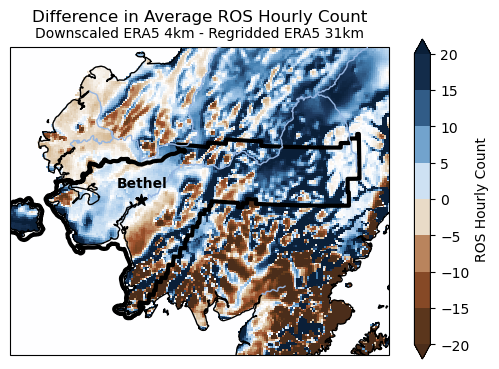

In [189]:
AK_ALBERS_SUBPLOT_KW = {'projection': ccrs.AlbersEqualArea(
       central_longitude=-154,
       central_latitude=50,
       standard_parallels=(55, 65))}

levels=np.arange(-20, 25, 5)
fig, ax = plt.subplots(subplot_kw=AK_ALBERS_SUBPLOT_KW, figsize=(10, 4))
fig.patch.set_alpha(0)
ax.set_facecolor('none')
pcm = ax.pcolormesh(lon, lat, Difference_ROS_seasonal,
   cmap=ros_colorbar,
   vmin=-20, vmax=20,
   shading='auto',
   transform=ccrs.PlateCarree())

cbar = fig.colorbar(pcm, ax=ax, boundaries=levels,label='ROS Hourly Count',extend='both')
cbar.set_ticks(levels)
cbar.ax.set_position([0.77, 0.1, 0.02, 0.8])

Bethel_boundary.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=3, zorder=2, transform=ccrs.PlateCarree())
Bethel_lon = -161.7554
Bethel_lat = 60.7913
ax.scatter(Bethel_lon, Bethel_lat, marker='*', color='black', s=75, zorder=12, transform=ccrs.PlateCarree())
ax.text(Bethel_lon, Bethel_lat + 0.2, 'Bethel', ha='center', va='bottom', fontsize=10,
       fontweight='bold', color='black', zorder=12, transform=ccrs.PlateCarree())
ax.add_feature(cfeature.BORDERS, zorder=9)
ax.add_feature(cfeature.COASTLINE, zorder=9)
ax.add_feature(cfeature.RIVERS, zorder=9)

ax.text(0.5, 1.03, "Downscaled ERA5 4km - Regridded ERA5 31km", transform=ax.transAxes, fontsize=10, ha='center')
ax.set_title("Difference in Average ROS Hourly Count\n")

ax.set_extent([-166.0, -152.0, 58.0, 63.5], crs=ccrs.PlateCarree())
ax.set_aspect('equal')
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.show()


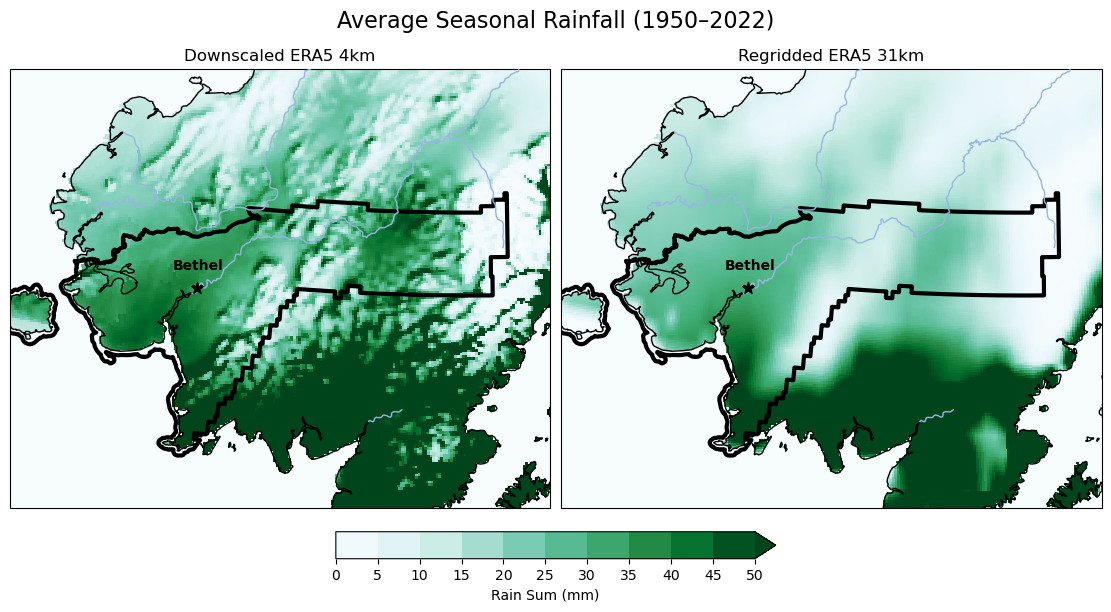

In [60]:
AK_ALBERS_SUBPLOT_KW = {
    'projection': ccrs.AlbersEqualArea(
        central_longitude=-154, central_latitude=50,
        standard_parallels=(55, 65))}

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(11,9), subplot_kw=AK_ALBERS_SUBPLOT_KW, constrained_layout=True)

# Create color map and levels
cmap = 'BuGn'
levels=np.arange(0, 55, 5)

# Use pcolormesh instead of contourf
pc1 = axs[0].pcolormesh(ROS_Rain_seasonal_sum_era5_4km['XLONG'], ROS_Rain_seasonal_sum_era5_4km['XLAT'], 
                        ROS_Rain_seasonal_sum_era5_4km, 
                        cmap=cmap, 
                        vmin=levels[0], vmax=levels[-1], 
                        shading='auto', transform=ccrs.PlateCarree())

axs[0].set_title("Downscaled ERA5 4km", fontsize=12)

# Use pcolormesh for ERA5 31km data
pc2 = axs[1].pcolormesh(ROS_RAIN_SUM_nearest_regridded_ERA5_31km['XLONG'], ROS_RAIN_SUM_nearest_regridded_ERA5_31km['XLAT'], 
                        ROS_RAIN_SUM_nearest_regridded_ERA5_31km, 
                        cmap=cmap, 
                        vmin=levels[0], vmax=levels[-1], 
                        shading='auto', transform=ccrs.PlateCarree())

axs[1].set_title("Regridded ERA5 31km", fontsize=12)


fig.suptitle("Average Seasonal Rainfall (1950–2022)",fontsize=16, y=0.81)
for ax in axs:
    Bethel_boundary.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=3, zorder=2, transform=ccrs.PlateCarree())
    Bethel_lon = -161.7554
    Bethel_lat = 60.7913
    ax.scatter(Bethel_lon, Bethel_lat, marker='*', color='black', s=75, zorder=12, transform=ccrs.PlateCarree())
    ax.text(Bethel_lon, Bethel_lat + 0.2, 'Bethel', ha='center', va='bottom', fontsize=10,
       fontweight='bold', color='black', zorder=12, transform=ccrs.PlateCarree())   
    ax.add_feature(cfeature.BORDERS, zorder=8)
    ax.add_feature(cfeature.COASTLINE, zorder=8)
    ax.add_feature(cfeature.RIVERS, zorder=8)
    ax.set_extent([-166.0, -152.0, 58.0, 63.5], crs=ccrs.PlateCarree())
    ax.set_aspect('equal')

cbar_ax = fig.add_axes([0.3, 0.2, 0.4, 0.03])
fig.colorbar(pc1,extend='max', boundaries=levels,cax=cbar_ax, orientation='horizontal', label='Rain Sum (mm)', ticks=levels)

fig.patch.set_alpha(0.0)
plt.show()

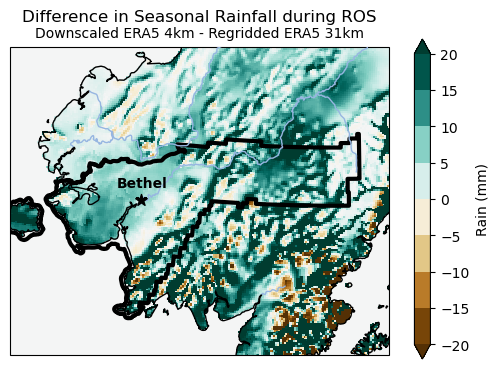

In [190]:
AK_ALBERS_SUBPLOT_KW = {'projection': ccrs.AlbersEqualArea(
       central_longitude=-154,
       central_latitude=50,
       standard_parallels=(55, 65))}

fig, ax = plt.subplots(subplot_kw=AK_ALBERS_SUBPLOT_KW, figsize=(10, 4))
fig.patch.set_alpha(0)

levels=np.arange(-20, 25, 5)
               
ax.set_facecolor('none')
pcm = ax.pcolormesh(lon, lat,Rain_difference,
   cmap='BrBG',
   vmin=-20, vmax=20,
   shading='auto',
   transform=ccrs.PlateCarree())

cbar = fig.colorbar(pcm, boundaries=levels, ax=ax, label='Rain (mm)',extend='both')
cbar.set_ticks(levels)
cbar.ax.set_position([0.77, 0.1, 0.02, 0.8])

Bethel_boundary.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=3, zorder=2, transform=ccrs.PlateCarree())
Bethel_lon = -161.7554
Bethel_lat = 60.7913
ax.scatter(Bethel_lon, Bethel_lat, marker='*', color='black', s=75, zorder=12, transform=ccrs.PlateCarree())
ax.text(Bethel_lon, Bethel_lat + 0.2, 'Bethel', ha='center', va='bottom', fontsize=10,
       fontweight='bold', color='black', zorder=12, transform=ccrs.PlateCarree())
ax.add_feature(cfeature.BORDERS, zorder=9)
ax.add_feature(cfeature.COASTLINE, zorder=9)
ax.add_feature(cfeature.RIVERS, zorder=9)

ax.set_title("Difference in Seasonal Rainfall during ROS\n")

ax.text(0.5, 1.03, "Downscaled ERA5 4km - Regridded ERA5 31km", transform=ax.transAxes, fontsize=10, ha='center')

ax.set_extent([-166.0, -152.0, 58.0, 63.5], crs=ccrs.PlateCarree())
ax.set_aspect('equal')
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.show()

Anchorage
-

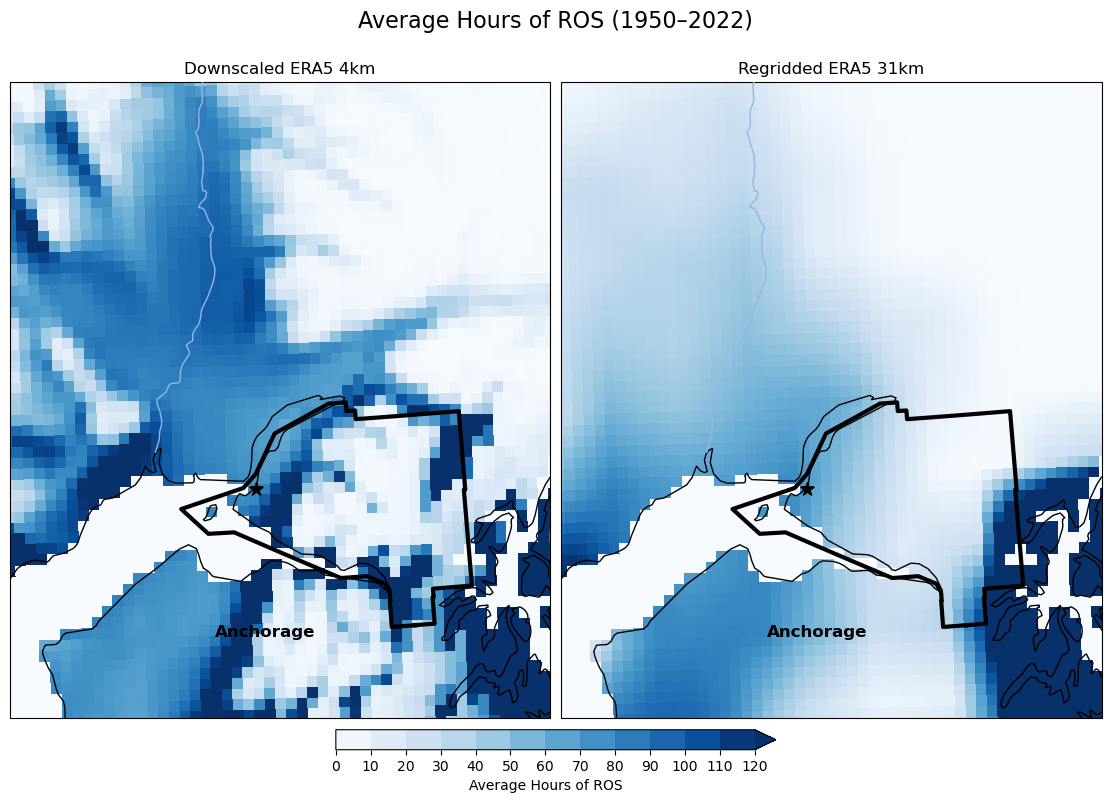

In [73]:
AK_ALBERS_SUBPLOT_KW = {
    'projection': ccrs.AlbersEqualArea(
        central_longitude=-154, central_latitude=50,
        standard_parallels=(55, 65))}

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(11,10), subplot_kw=AK_ALBERS_SUBPLOT_KW, constrained_layout=True)

# Create color map and levels
cmap = 'Blues'
levels=np.arange(0,130,10)

# Use pcolormesh instead of contourf
pc1 = axs[0].pcolormesh(ROS_Tally_era5_4km['XLONG'], ROS_Tally_era5_4km['XLAT'], 
                        ROS_Tally_seasonal_era5_4km, 
                        cmap=cmap, 
                        vmin=levels[0], vmax=levels[-1], 
                        shading='auto', transform=ccrs.PlateCarree())

axs[0].set_title("Downscaled ERA5 4km", fontsize=12)

# Use pcolormesh for ERA5 31km data
pc2 = axs[1].pcolormesh(ROS_Tally_seasonal_nearest_regridded_ERA5_31km['XLONG'], ROS_Tally_seasonal_nearest_regridded_ERA5_31km['XLAT'], 
                        ROS_Tally_seasonal_nearest_regridded_ERA5_31km, 
                        cmap=cmap, 
                        vmin=levels[0], vmax=levels[-1], 
                        shading='auto', transform=ccrs.PlateCarree())

axs[1].set_title("Regridded ERA5 31km", fontsize=12)

for ax in axs:
    Mun_of_Anc_boundary.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=3, zorder=2, transform=ccrs.PlateCarree())
    Anchorage_lon = -149.9003
    Anchorage_lat = 61.2181
    ax.scatter(Anchorage_lon, Anchorage_lat, marker='*', color='black', s=100,zorder=9, transform=ccrs.PlateCarree())
    ax.text(Anchorage_lon, Anchorage_lat - 0.5, 'Anchorage', ha='center', va='bottom', fontsize=12,
       fontweight='bold', color='black', zorder=10, transform=ccrs.PlateCarree())

    ax.add_feature(cfeature.BORDERS, zorder=8)
    ax.add_feature(cfeature.COASTLINE, zorder=8)
    ax.add_feature(cfeature.RIVERS, zorder=8)
    ax.set_extent([-151.5, -148, 60.5, 62.5], crs=ccrs.PlateCarree()) 
    ax.set_aspect('equal')

cbar_ax = fig.add_axes([0.3, 0.15, 0.4, 0.02])
fig.colorbar(pc1, cax=cbar_ax, boundaries=levels, orientation='horizontal', label='Average Hours of ROS', ticks=levels,extend='max')

fig.suptitle("Average Hours of ROS (1950–2022)",fontsize=16, y=0.89)

fig.patch.set_alpha(0.0)
plt.show()

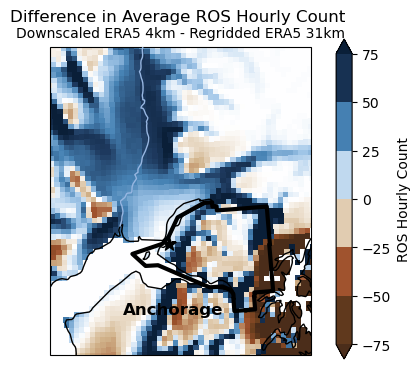

In [192]:
AK_ALBERS_SUBPLOT_KW = {'projection': ccrs.AlbersEqualArea(
       central_longitude=-154,
       central_latitude=50,
       standard_parallels=(55, 65))}

fig, ax = plt.subplots(subplot_kw=AK_ALBERS_SUBPLOT_KW, figsize=(10, 4))
fig.patch.set_alpha(0)
ax.set_facecolor('none')

levels=np.arange(-75,100, 25)

pcm = ax.pcolormesh(lon, lat, Difference_ROS_seasonal,
   cmap=ros_colorbar,
   vmin=-75, vmax=75,
   shading='auto',
   transform=ccrs.PlateCarree())

cbar = fig.colorbar(pcm, ax=ax, boundaries=levels,label='ROS Hourly Count',extend='both')
cbar.set_ticks(levels)
cbar.ax.set_position([0.77, 0.1, 0.02, 0.8])

Mun_of_Anc_boundary.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=3, zorder=2, transform=ccrs.PlateCarree())
Anchorage_lon = -149.9003
Anchorage_lat = 61.2181
ax.scatter(Anchorage_lon, Anchorage_lat, marker='*', color='black', s=100,zorder=9, transform=ccrs.PlateCarree())
ax.text(Anchorage_lon, Anchorage_lat - 0.5, 'Anchorage', ha='center', va='bottom', fontsize=12,
       fontweight='bold', color='black', zorder=10, transform=ccrs.PlateCarree())

ax.add_feature(cfeature.BORDERS, zorder=9)
ax.add_feature(cfeature.COASTLINE, zorder=9)
ax.add_feature(cfeature.RIVERS, zorder=9)

ax.set_title("Difference in Average ROS Hourly Count \n")
ax.text(0.5, 1.03, "Downscaled ERA5 4km - Regridded ERA5 31km", transform=ax.transAxes, fontsize=10, ha='center')
#   "Regridded 4km ERA5 - ERA5 31km)
ax.set_extent([-151.5, -148, 60.5, 62.5], crs=ccrs.PlateCarree()) 
ax.set_aspect('equal')
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.show()

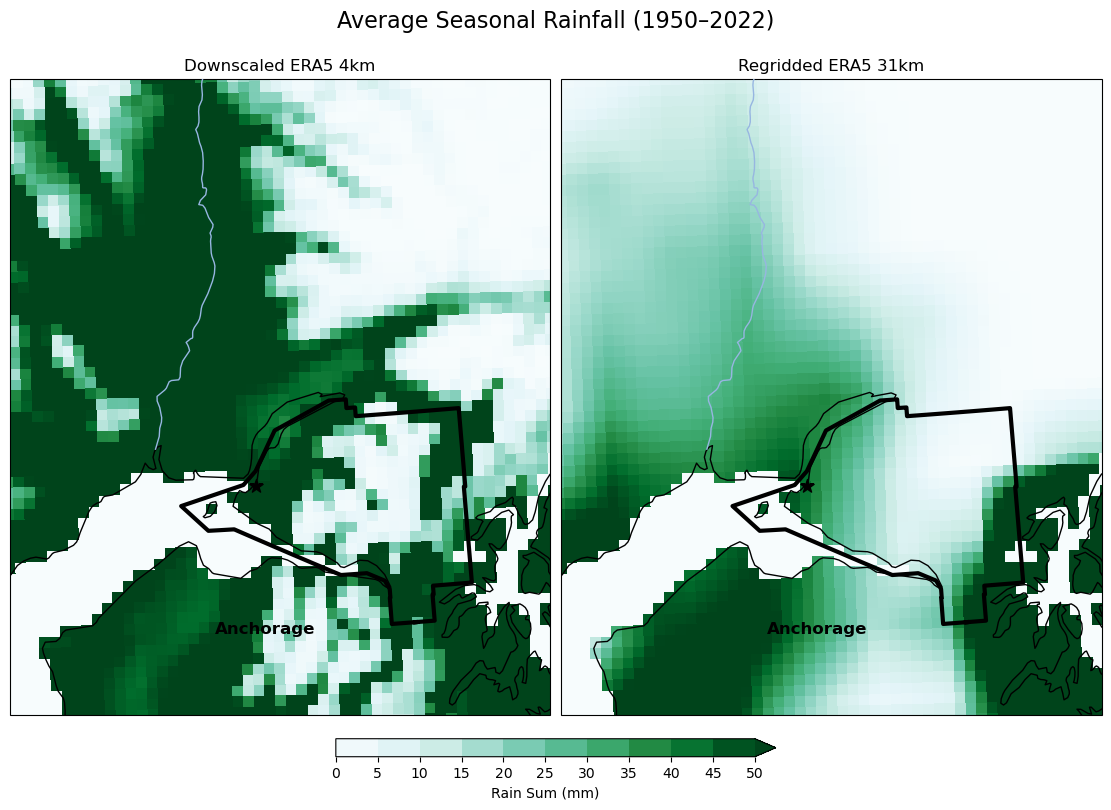

In [91]:
AK_ALBERS_SUBPLOT_KW = {
    'projection': ccrs.AlbersEqualArea(
        central_longitude=-154, central_latitude=50,
        standard_parallels=(55, 65))}

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(11,9), subplot_kw=AK_ALBERS_SUBPLOT_KW, constrained_layout=True)

# Create color map and levels
cmap = 'BuGn'
levels=np.arange(0, 55, 5)

# Use pcolormesh instead of contourf
pc1 = axs[0].pcolormesh(ROS_Rain_seasonal_sum_era5_4km['XLONG'], ROS_Rain_seasonal_sum_era5_4km['XLAT'], 
                        ROS_Rain_seasonal_sum_era5_4km, 
                        cmap=cmap, 
                        vmin=levels[0], vmax=levels[-1], 
                        shading='auto', transform=ccrs.PlateCarree())

axs[0].set_title("Downscaled ERA5 4km", fontsize=12)

# Use pcolormesh for ERA5 31km data
pc2 = axs[1].pcolormesh(ROS_RAIN_SUM_nearest_regridded_ERA5_31km['XLONG'], ROS_RAIN_SUM_nearest_regridded_ERA5_31km['XLAT'], 
                        ROS_RAIN_SUM_nearest_regridded_ERA5_31km, 
                        cmap=cmap, 
                        vmin=levels[0], vmax=levels[-1], 
                        shading='auto', transform=ccrs.PlateCarree())
#average seasonal sum of rainfall during ROS events 
#Average Seasonal Rainfall from Winter 1950-2022 
axs[1].set_title("Regridded ERA5 31km", fontsize=12)

for ax in axs:
    Mun_of_Anc_boundary.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=3, zorder=2, transform=ccrs.PlateCarree())
    Anchorage_lon = -149.9003
    Anchorage_lat = 61.2181
    ax.scatter(Anchorage_lon, Anchorage_lat, marker='*', color='black', s=100,zorder=9, transform=ccrs.PlateCarree())
    ax.text(Anchorage_lon, Anchorage_lat - 0.5, 'Anchorage', ha='center', va='bottom', fontsize=12,
       fontweight='bold', color='black', zorder=10, transform=ccrs.PlateCarree())

    ax.add_feature(cfeature.BORDERS, zorder=8)
    ax.add_feature(cfeature.COASTLINE, zorder=8)
    ax.add_feature(cfeature.RIVERS, zorder=8)
    ax.set_extent([-151.5, -148, 60.5, 62.5], crs=ccrs.PlateCarree()) 
    ax.set_aspect('equal')
cbar_ax = fig.add_axes([0.3, 0.1, 0.4, 0.02])
fig.colorbar(pc1,extend='max', boundaries=levels,cax=cbar_ax, orientation='horizontal', label='Rain Sum (mm)', ticks=levels)
fig.suptitle("Average Seasonal Rainfall (1950–2022)",fontsize=16, y=0.93)

fig.patch.set_alpha(0.0)
plt.show()

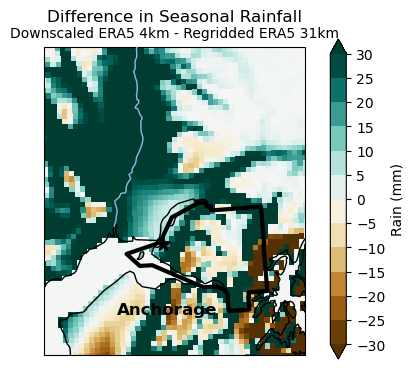

In [116]:
AK_ALBERS_SUBPLOT_KW = {'projection': ccrs.AlbersEqualArea(
       central_longitude=-154,
       central_latitude=50,
       standard_parallels=(55, 65))}

fig, ax = plt.subplots(subplot_kw=AK_ALBERS_SUBPLOT_KW, figsize=(10, 4))
fig.patch.set_alpha(0)
ax.set_facecolor('none')
levels=np.arange(-30, 35,5)
pcm = ax.pcolormesh(lon, lat, Rain_difference,
   cmap='BrBG',
   vmin=-30, vmax=30,
   shading='auto',
   transform=ccrs.PlateCarree())

cbar = fig.colorbar(pcm, ax=ax, boundaries=levels,label='Rain (mm)',extend='both')
cbar.set_ticks(levels)
cbar.ax.set_position([0.77, 0.1, 0.02, 0.8])

Mun_of_Anc_boundary.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=3, zorder=2, transform=ccrs.PlateCarree())
Anchorage_lon = -149.9003
Anchorage_lat = 61.2181
ax.scatter(Anchorage_lon, Anchorage_lat, marker='*', color='black', s=100,zorder=9, transform=ccrs.PlateCarree())
ax.text(Anchorage_lon, Anchorage_lat - 0.5, 'Anchorage', ha='center', va='bottom', fontsize=12,
       fontweight='bold', color='black', zorder=10, transform=ccrs.PlateCarree())

ax.add_feature(cfeature.BORDERS, zorder=9)
ax.add_feature(cfeature.COASTLINE, zorder=9)
ax.add_feature(cfeature.RIVERS, zorder=9)

ax.set_title("Difference in Seasonal Rainfall\n")
ax.text(0.5, 1.03, "Downscaled ERA5 4km - Regridded ERA5 31km", transform=ax.transAxes, fontsize=10, ha='center')

ax.set_extent([-151.5, -148, 60.5, 62.5], crs=ccrs.PlateCarree()) 
ax.set_aspect('equal')
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.show()

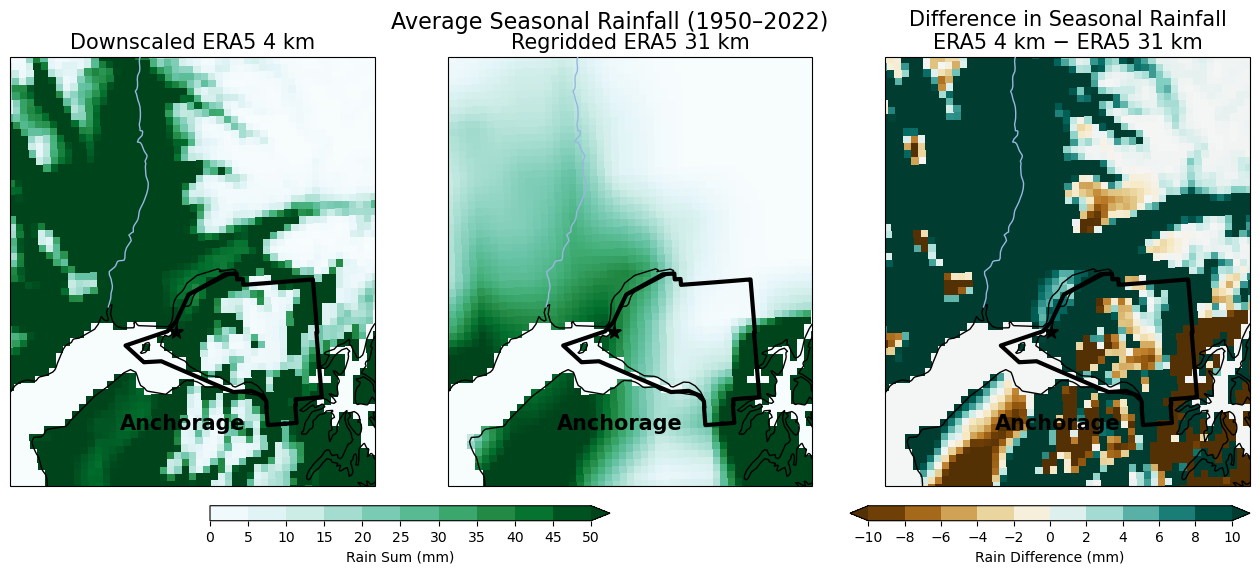

In [117]:
AK_ALBERS_SUBPLOT_KW = {
    'projection': ccrs.AlbersEqualArea(
        central_longitude=-154,
        central_latitude=50,
        standard_parallels=(55, 65))
}

fig, axs = plt.subplots(
    nrows=1, ncols=3,
    figsize=(16, 6),
    subplot_kw=AK_ALBERS_SUBPLOT_KW)

cmap_main = 'BuGn'
levels = np.linspace(0, 50, 100)

cmap_diff = 'BrBG'
vmin_diff, vmax_diff = -10, 10

extent = [-151.5, -148, 60.5, 62.5]

Anchorage_lon = -149.9003
Anchorage_lat = 61.2181

pc1 = axs[0].pcolormesh(
    ROS_Rain_seasonal_sum_era5_4km['XLONG'],
    ROS_Rain_seasonal_sum_era5_4km['XLAT'],
    ROS_Rain_seasonal_sum_era5_4km,
    cmap=cmap_main,
    vmin=levels[0], vmax=levels[-1],
    shading='auto',
    transform=ccrs.PlateCarree()
)

axs[0].set_title(
    "Downscaled ERA5 4 km",
    fontsize=15
)

pc2 = axs[1].pcolormesh(
    ROS_RAIN_SUM_nearest_regridded_ERA5_31km['XLONG'],
    ROS_RAIN_SUM_nearest_regridded_ERA5_31km['XLAT'],
    ROS_RAIN_SUM_nearest_regridded_ERA5_31km,
    cmap=cmap_main,
    vmin=levels[0], vmax=levels[-1],
    shading='auto',
    transform=ccrs.PlateCarree()
)

axs[1].set_title(
    "Regridded ERA5 31 km",
    fontsize=15
)

pc3 = axs[2].pcolormesh(
    lon, lat, Rain_difference,
    cmap=cmap_diff,
    vmin=vmin_diff, vmax=vmax_diff,
    shading='auto',
    transform=ccrs.PlateCarree()
)

axs[2].set_title(
    "Difference in Seasonal Rainfall\nERA5 4 km − ERA5 31 km",
    fontsize=15
)

for ax in axs:
    Mun_of_Anc_boundary.plot(
        ax=ax, facecolor='none',
        edgecolor='black', linewidth=3,
        zorder=2, transform=ccrs.PlateCarree()
    )

    ax.scatter(
        Anchorage_lon, Anchorage_lat,
        marker='*', color='black', s=100,
        zorder=9, transform=ccrs.PlateCarree()
    )

    ax.text(
        Anchorage_lon, Anchorage_lat - 0.5,
        'Anchorage',
        ha='center', va='bottom',
        fontsize=15, fontweight='bold',
        zorder=10, transform=ccrs.PlateCarree()
    )

    ax.add_feature(cfeature.BORDERS, zorder=8)
    ax.add_feature(cfeature.COASTLINE, zorder=8)
    ax.add_feature(cfeature.RIVERS, zorder=8)

    ax.set_extent(extent, crs=ccrs.PlateCarree())
    ax.set_aspect('equal')

fig.suptitle("Average Seasonal Rainfall (1950–2022)",fontsize=16, y=0.93)
levels=np.arange(0, 55, 5)
cbar_ax1 = fig.add_axes([0.25, 0.08, 0.25, 0.025])
fig.colorbar(
    pc1,
    cax=cbar_ax1, boundaries=levels,
    orientation='horizontal',
    extend='max',
    label='Rain Sum (mm)',
    ticks=levels
)

# Difference colorbar (panel 3)
levels=np.arange(-10, 12, 2)
cbar_ax2 = fig.add_axes([0.65, 0.08, 0.25, 0.025])
fig.colorbar(
    pc3,
    cax=cbar_ax2,
    orientation='horizontal', boundaries=levels,
    extend='both',
    label='Rain Difference (mm)',
    ticks=levels)

fig.patch.set_alpha(0.0)
plt.show()
